In [4]:
import logging
import sys
import os
import string
from itertools import islice, combinations_with_replacement
logging.basicConfig(level=logging.DEBUG)


import altair
from altair import Chart, Color, X, Y, Row
import pandas as pd
import numpy as np
from IPython.display import Audio, display
from scipy import fft, ifft
from scipy.signal import resample, sawtooth, square, fftconvolve
from scipy.linalg import toeplitz
from scipy.io import wavfile
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt
%matplotlib inline

# assuming paths and __init__.py are in place..., import utility files
from utils import shift_wavs
from utils.plot_stuff import plot_signals
from utils.compare_signals import compare_signals

# Experiments with Koldovsky & Tichavsky ICA Technique

[PDF](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.457.7646&rep=rep1&type=pdf) of the paper.

1. Augment observed input signals by creating $L$ delayed versions of each signal, stack into a matrix.
2. Do ICA on augmented input
3. Compute pairwise similarity of all components, perform agglomerative clustering
4. Transform component clusters back to augmented observation space, then un-delay and combine.

## Data: superposition of simple signals

### Sources

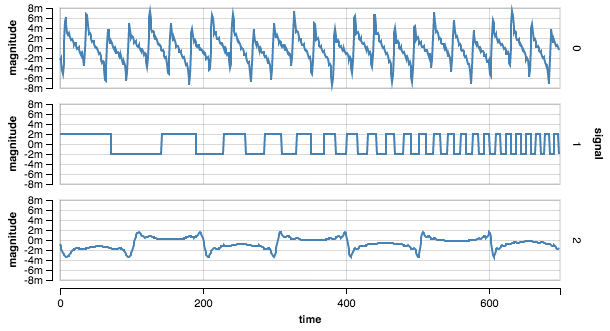

In [2]:
ts = np.linspace(0.0,3.0,num=8000*3)
hz1 = 170
sig1 = np.sum([np.sin(ts*harm*hz1*(np.sin(ts)+1.5)*2.0*np.pi+np.sin(ts*500)/4.0, dtype=np.float32) * 0.005/(harm+1) for harm in range(7)],axis=0)
hz2 = 430
sig2 = square(np.sin((ts*4))**4*hz2*2.0*np.pi).astype(np.float32) * 0.002
sig3 = np.sum([np.sin(50+(np.sin(ts*250)*0.01)*ts*harm*hz2*2.0*np.pi).astype(np.float32) * 0.002/(harm+1) for harm in range(10)],axis=0)
sigs = np.vstack((sig1,sig2,sig3))
plot_signals(sigs[:,300:1000]).configure_cell(height=80).display()

In [3]:
display(Audio(sig1,rate=8000))
display(Audio(sig2,rate=8000))
display(Audio(sig3,rate=8000))
wavfile.write("space_sound.wav",8000,sig3)

### Observations

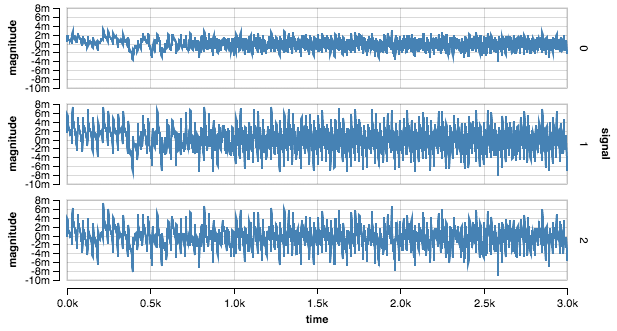

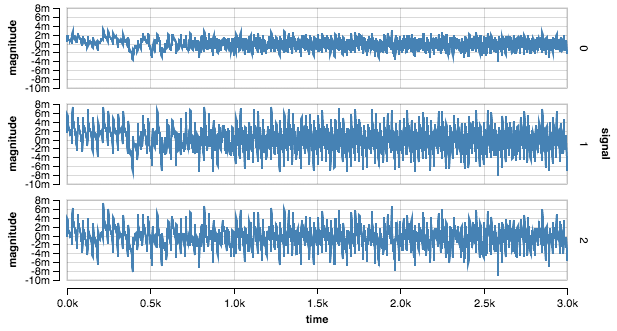

In [4]:
mixing_system_1 = np.random.rand(1, 3)
mixing_system_2 = np.random.rand(2, 3)
mixing_system_3 = np.random.rand(3, 3)



mic_obs = mixing_system_3 @ sigs + np.random.randn(1, sigs.shape[1]) * 0.0001

plot_signals(mic_obs[:,:3000]).configure_cell(height=80).display()
for i in range(mic_obs.shape[0]):
    display(Audio(mic_obs[i,:],rate=8000,autoplay=False))


### Construct Delayed Observation Matrix

In [5]:
clip_start = 8000
clip_end = 20000
num_delays = 20
num_signals = mic_obs.shape[0]

In [6]:
shifted_obs = np.zeros((num_signals*num_delays, clip_end-clip_start), dtype=mic_obs.dtype)
num_samples = shifted_obs.shape[1]

In [7]:
for sig_idx in range(num_signals):
    first_col = mic_obs[sig_idx,clip_start:(clip_start - num_delays):-1]
    first_row = mic_obs[sig_idx, clip_start:clip_end]
    shifted_obs[(num_delays*sig_idx):(num_delays + num_delays*sig_idx)] = toeplitz(first_col, first_row)

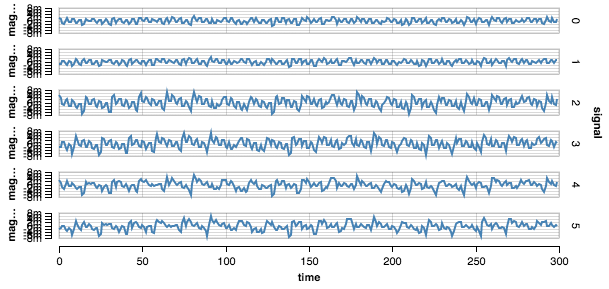

In [8]:
plot_signals(shifted_obs[::num_delays//2,:300]).configure_cell(height=25)

## Decompose

### Use FastICA on signals

In [9]:
from sklearn.decomposition import FastICA

fastica = FastICA(n_components=num_signals*num_delays, max_iter=10000, tol=0.00001, whiten=True)
components = fastica.fit_transform(shifted_obs.T).T

/Users/patrickc/anaconda3/envs/magnolia3/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


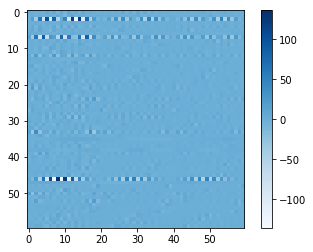

In [10]:
plt.imshow(fastica.components_, cmap='Blues', interpolation='nearest')
plt.colorbar()

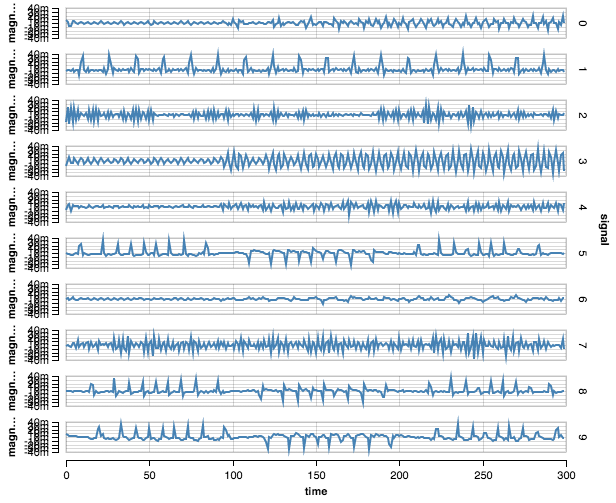

In [11]:
plot_signals(components[:10,:300]).configure_cell(height=30)

In [12]:
for i, component in enumerate(components):
    print(i,end=': ')
    display(Audio(component, rate=8000))

0: 

1: 

2: 

3: 

4: 

5: 

6: 

7: 

8: 

9: 

10: 

11: 

12: 

13: 

14: 

15: 

16: 

17: 

18: 

19: 

20: 

21: 

22: 

23: 

24: 

25: 

26: 

27: 

28: 

29: 

30: 

31: 

32: 

33: 

34: 

35: 

36: 

37: 

38: 

39: 

40: 

41: 

42: 

43: 

44: 

45: 

46: 

47: 

48: 

49: 

50: 

51: 

52: 

53: 

54: 

55: 

56: 

57: 

58: 

59: 

## Similarity Metric between Components

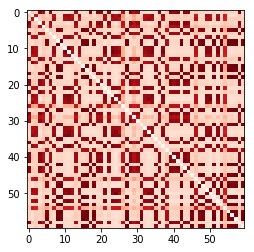

In [13]:
com_sims = compare_signals(components)

plt.imshow(com_sims, cmap='Reds', interpolation='nearest')

## Agglomerative Clustering

In [14]:
num_srcs = sigs.shape[0]
agg = AgglomerativeClustering(n_clusters=num_srcs)
agg.fit(com_sims)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward',
            memory=Memory(cachedir=None), n_clusters=3,
            pooling_func=<function mean at 0x10ac2c840>)

[0 2 2 0 0 1 0 2 1 1 2 2 2 0 2 1 1 0 1 0 0 2 0 2 2 2 0 1 0 0 0 1 2 2 2 1 0
 2 1 0 0 0 1 0 0 1 2 1 1 2 2 1 2 1 2 1 1 1 0 1]


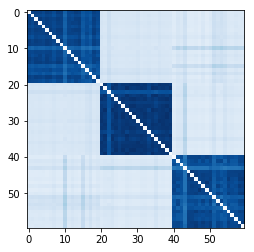

In [15]:
sim_idxs = np.argsort(agg.labels_)
print(agg.labels_)
plt.imshow(com_sims[sim_idxs][:,sim_idxs], cmap='Blues', interpolation='nearest')

## Reconstruction

In [16]:
# Get back into space of the augmented input
reconstruction_weights = np.zeros((num_srcs, len(components), len(components)), dtype=shifted_obs.dtype)
for i in range(num_srcs):
    reconstruction_weights[i,:,:] = np.linalg.pinv(fastica.components_) @ np.diag(agg.labels_ == i) @ fastica.components_

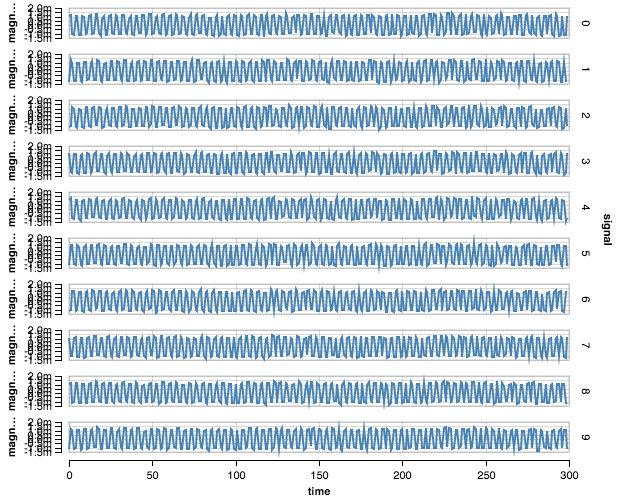

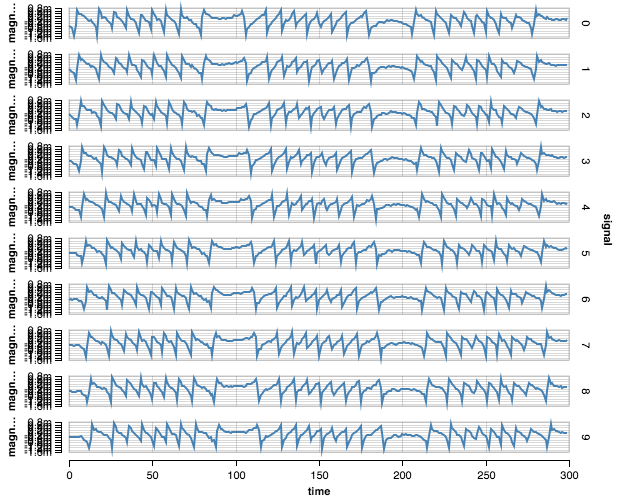

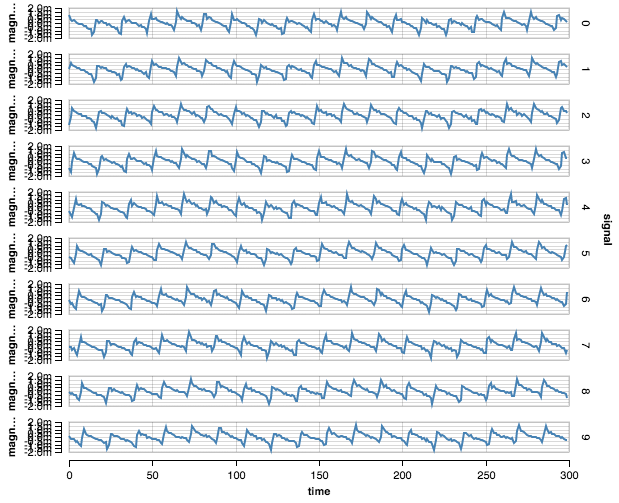

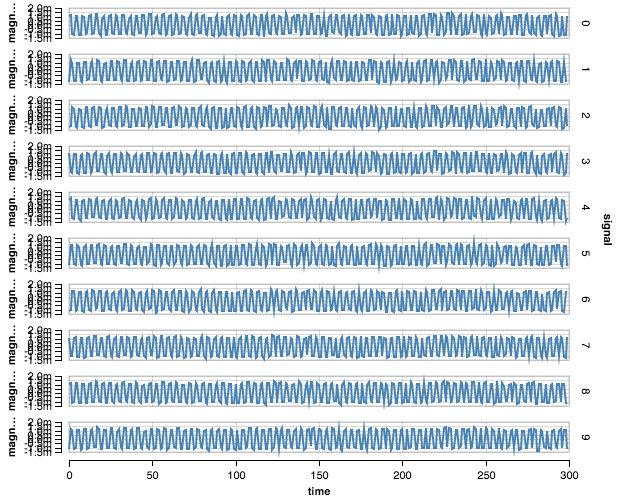

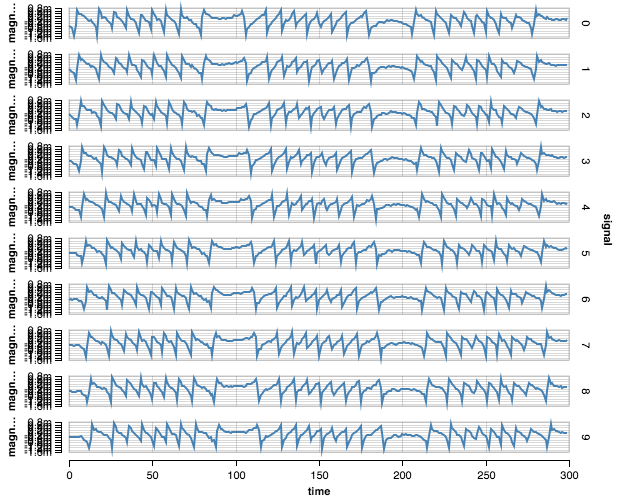

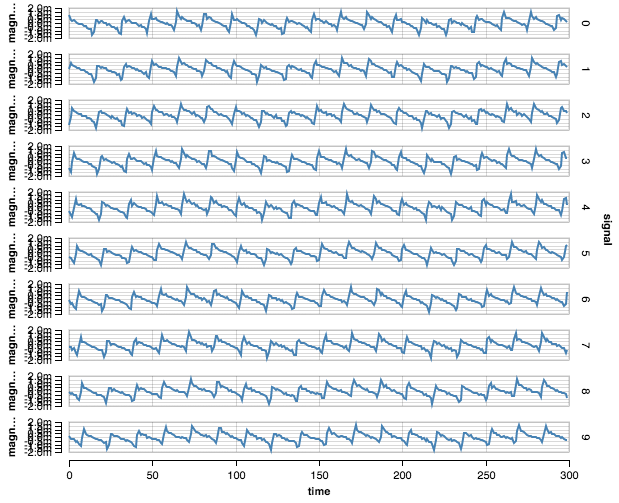

In [17]:
reconstructed = np.zeros((num_srcs,*shifted_obs.shape), dtype=shifted_obs.dtype)
for i in range(num_srcs):
    reconstructed[i,:,:] = reconstruction_weights[i] @ shifted_obs
    plot_signals(reconstructed[i,:10,:300]).configure_cell(height=30).display()

In [18]:
# Reconstruct sources, accounting for original artificial lags
src_imgs_est = np.zeros((num_srcs, num_signals, num_samples), dtype=shifted_obs.dtype)
for clus in range(num_srcs):
    for lag in range(num_delays):
        for sig in range(num_signals):
            for n in range(num_samples - num_delays):
                src_imgs_est[clus, sig, n] = reconstructed[clus, (sig)*num_delays + lag, n + lag]

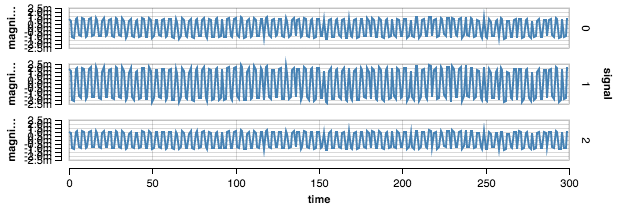

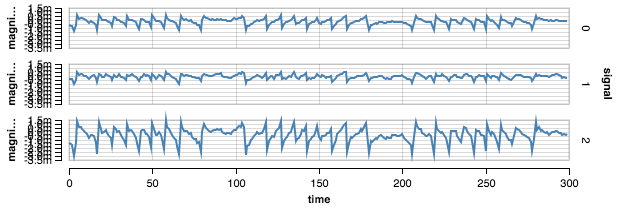

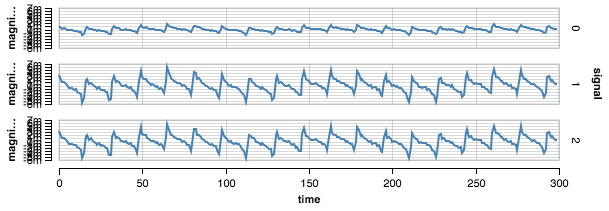

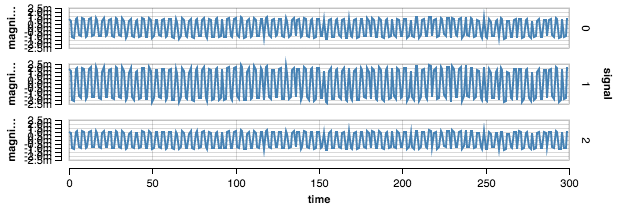

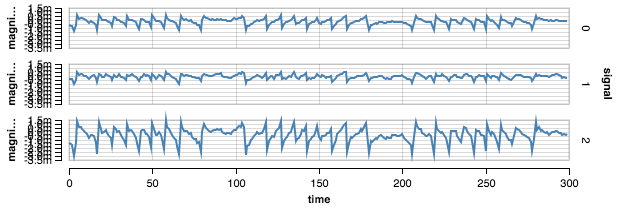

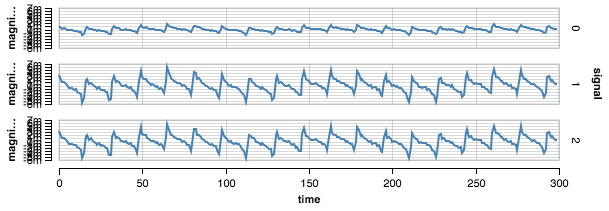

In [19]:
for i in range(num_srcs):
    plot_signals(src_imgs_est[i,:,:300]).configure_cell(height=40).display()

In [20]:
# Delay-and-sum of resulting components
recon_mono = np.zeros((num_srcs, num_samples), dtype=np.float64)
for i in range(num_srcs):
    if src_imgs_est.shape[1] > 1:
        recon_mono[i] = np.sum([shift_wavs.shift_signal(src_imgs_est[i,0],src_imgs_est[i,j]) for j in range(1,src_imgs_est.shape[1])], axis=0)
    else:
        recon_mono[i] = src_imgs_est[i]
    display(Audio(recon_mono[i], rate=8000))

INFO:shift_wavs:(23999,)
INFO:shift_wavs:(23999,)
INFO:shift_wavs:Truncate head...1
INFO:shift_wavs:(23999,)
INFO:shift_wavs:(23999,)
INFO:shift_wavs:Truncate head...1


INFO:shift_wavs:(23999,)
INFO:shift_wavs:(23999,)
INFO:shift_wavs:Truncate head...1
INFO:shift_wavs:(23999,)
INFO:shift_wavs:(23999,)
INFO:shift_wavs:Truncate head...1


INFO:shift_wavs:(23999,)
INFO:shift_wavs:(23999,)
INFO:shift_wavs:Truncate head...1
INFO:shift_wavs:(23999,)
INFO:shift_wavs:(23999,)
INFO:shift_wavs:Truncate head...1
